In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import datetime
from datetime import timedelta
import random
from importlib import reload
from IPython.display import Audio
import m5forecasting as m5
import matplotlib.pyplot as plt
sound_file = './sound/radio.wav'
from collections import Counter

In [2]:
df = m5.df
all_data = m5.all_data

In [299]:
events = [event[0] for event in list(Counter(m5.calendar["event_name_1"]).items())]
event_dict = {}
for idx, event in enumerate(events):
    event_dict[event] = idx

eventTypes = [eventType[0] for eventType in list(Counter(m5.calendar["event_type_1"]).items())]
event_type_dict = {}
for idx, eventType in enumerate(eventTypes):
    event_type_dict[eventType] = idx

def getEvent(day):
    row = m5.calendar.iloc[day - 1]
    event_name = event_dict[row["event_name_1"]]
    event_type = event_type_dict[row["event_type_1"]]
    return np.array([event_name, event_type])

In [294]:
%%time
for i in range(1913 * 10):
    temp = m5.calendar[m5.calendar.d == "d_" + str((i + 1) % 1913)]

CPU times: user 9.38 s, sys: 30.3 ms, total: 9.41 s
Wall time: 9.43 s


In [295]:
%%time
for i in range(1913 * 10):
    temp = m5.calendar.iloc[i % 1913]

CPU times: user 2.27 s, sys: 6.6 ms, total: 2.27 s
Wall time: 2.28 s


In [368]:
"{}%".format(10)

'10%'

## Feature Generation

In [393]:
def getYearMonthDay(day):
    temp = datetime(2011,1,28) + timedelta(days=day)
    return [temp.year, temp.month, temp.day]

def getDay(day):
    temp = day % 7
    return [temp, int(temp > 0 and temp < 3)]

def getSnapValue(day, state_index):
    return int(m5.calendar.iloc[day - 1, 11 + state_index])

events = [event[0] for event in list(Counter(m5.calendar["event_name_1"]).items())]
event_dict = {}
for idx, event in enumerate(events):
    event_dict[event] = idx

eventTypes = [eventType[0] for eventType in list(Counter(m5.calendar["event_type_1"]).items())]
event_type_dict = {}
for idx, eventType in enumerate(eventTypes):
    event_type_dict[eventType] = idx

def getEvent(day):
    row = m5.calendar.iloc[day - 1]
    event_name = event_dict[row["event_name_1"]]
    event_type = event_type_dict[row["event_type_1"]]
    return np.array([event_name, event_type])

# item number, item department, item category, store, state
departmentInt = {}
current_id = "HOBBIES_1"
count = 0
for i in range(3049):
    if df.iloc[i]["dept_id"] != current_id or i == 3048:
        departmentInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["dept_id"]

categoryInt = {}
current_id = "HOBBIES"
count = 0
for i in range(3049):
    if df.iloc[i]["cat_id"] != current_id or i == 3048:
        categoryInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["cat_id"]

storeInt = {}
current_id = "CA_1"
count = 0
for i in range(0,30490,3049):
    if df.iloc[i]["store_id"] != current_id:
        storeInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["store_id"]
        storeInt[current_id] = count

stateInt = {}
current_id = "CA"
count = 0
for i in range(0,30490,3049):
    if df.iloc[i]["state_id"] != current_id:
        stateInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["state_id"]
        stateInt[current_id] = count

def generateTrainingData(start_day, end_day, lags, rolling, all_data, withLabels = True, verbose=False):
    num_days = end_day - start_day + 1
    num_series = 30490
    total_entries = num_days * num_series
    training_data = np.zeros((total_entries, len(lags)))
    categoricalfeatures = [0] * len(lags)
    if withLabels:
        training_labels = np.zeros(total_entries)
    
    # lag features
    count = 0
    for time_series_idx in range(30490):
        for i in range(end_day - num_days,end_day):
            training_data[count] = all_data[time_series_idx, [i - lag for lag in lags]]
            if withLabels:
                training_labels[count] = all_data[time_series_idx, i]
            count += 1
    
    if verbose:
        print("Finished lag features")
    
    # rolling lag features
    count = 0
    categoricalfeatures.extend([0] * len(rolling))
    temp_training = np.zeros((total_entries, len(rolling)))
    for time_series_idx in range(30490):
        for i in range(end_day - num_days,end_day):
            temp_training[count] = [all_data[time_series_idx, [i - lag for lag in rolling_lags]].sum() / len(rolling_lags) for rolling_lags in rolling]
            count += 1
        if verbose and ((time_series_idx + 1) % 3049 == 0):
            print("{}% done with rolling".format((time_series_idx + 1) // 3049 * 10))
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished rolling lag features")
    
    # item features - item number, department, category, store, state, store * department
    temp_training = np.zeros((total_entries, 8))
    categoricalfeatures.extend([1] * 8)
    for i in range(0, total_entries, num_days):
        item_number = i // num_days % 3049
        dep_num = departmentInt[df["dept_id"].iloc[item_number]]
        store_num = storeInt[df["store_id"].iloc[i // num_days]]
        temp_training[i:i + num_days, 0] = item_number
        temp_training[i:i + num_days, 1] = dep_num
        temp_training[i:i + num_days, 2] = categoryInt[df["cat_id"].iloc[item_number]]
        temp_training[i:i + num_days, 3] = store_num
        temp_training[i:i + num_days, 4] = stateInt[df["state_id"].iloc[i // num_days]]
        temp_training[i:i + num_days, 5] = store_num * 7 + dep_num
    
    if verbose:
        print("Finished item features")
    
    # day of week and is weekend
    for i in range(num_days):
        temp_training[i::num_days, 6:8] = getDay(i % num_days + (end_day + 1 - num_days))
    training_data = np.concatenate((training_data, temp_training), axis=1)
   
    if verbose:
        print("Finished day features")
   
    # snap feature
    temp_training = np.zeros((total_entries, 1))
    categoricalfeatures.append(1)
    for idx, day in enumerate(range(start_day, end_day + 1)):
        temp_training[idx:idx + 3049 * 4 * num_days:num_days, 0] = getSnapValue(day, 0)
        temp_training[idx + 3049 * 4 * num_days:idx + 3049 * 7 * num_days:num_days, 0] = getSnapValue(day, 1)
        temp_training[idx + 3049 * 7 * num_days:idx + 3049 * 10 * num_days:num_days, 0] = getSnapValue(day, 2)
    training_data = np.concatenate((training_data, temp_training), axis=1)
   
    # month, day, year
    temp_training = np.zeros((total_entries, 3))
    categoricalfeatures.extend([1] * 3)
    for i in range(num_days):
        temp_training[i::num_days] = getYearMonthDay(i % num_days + (end_day + 1 - num_days))
    training_data = np.concatenate((training_data, temp_training), axis=1)
   
    if verbose:
        print("Finished date features")
   
    # special events
    temp_training = np.zeros((total_entries, 10))
    categoricalfeatures.extend([1] * 10)
    for idx, day in enumerate(range(start_day, end_day + 1)):
            temp_training[idx:total_entries:num_days, :2] = getEvent(day)
            ev1 = np.zeros(2)
            ev2 = np.zeros(2)
            for idx2, day2 in enumerate(range(day - 1, day - 8, -1)):
                temp_ev = getEvent(day2)
                if temp_ev[0] != 0:
                    if ev1[0] == 0:
                        ev1 = temp_ev
                    elif ev2[0] == 0:
                        ev2 = temp_ev
            temp_training[idx:total_entries:num_days, 2:4] = ev1
            temp_training[idx:total_entries:num_days, 4:6] = ev2
            ev1 = np.zeros(2)
            ev2 = np.zeros(2)
            for idx2, day2 in enumerate(range(day + 1, day + 8)):
                temp_ev = getEvent(day2)
                if temp_ev[0] != 0:
                    if ev1[0] == 0:
                        ev1 = temp_ev
                    elif ev2[0] == 0:
                        ev2 = temp_ev
            temp_training[idx:total_entries:num_days, 6:8] = ev1
            temp_training[idx:total_entries:num_days, 8:10] = ev2
                        
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished event features")
    
    if withLabels:
        return training_data, training_labels, [idx for idx, val in enumerate(categoricalfeatures) if val == 1]
    else:
        return training_data

In [357]:
temp_arr = [1,2,3]
reversed(temp_arr)
temp_arr

[1, 2, 3]

In [367]:
dept_idxs = []
current_dep = ""
for i in range(3049):
    if df.iloc[i]["dept_id"] != current_dep:
        current_dep = df.iloc[i]["dept_id"]
        dept_idxs.append(i)

In [372]:
dept_idxs

[0, 416, 565, 1097, 1612, 1828, 2226]

## Model Training / Testing

In [627]:
def custom_asymmetric_train(y_pred, y_true):
    # y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2.0 * residual, -2 * residual * 1.15)
    hess = np.where(residual < 0, 2.0, 2.0 * 1.15)
    return grad, hess

def custom_asymmetric_valid(y_pred, y_true):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [608]:
np.power(np.arange(4), 2)

array([0, 1, 4, 9])

In [5]:
def Level_12_WRMSSE(y_pred, y_true):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float")
    diff_squared = (diff * diff).reshape((30490, 28))
    return "Lev 12", np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[12] / 12.0), False

def Level_1_WRMSSE(y_pred, y_true):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float").reshape((30490, 28))
    diff_squared = np.square(m5.transformer[1](diff))
    return "Lev 1", np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[1] / 12.0), False

In [391]:
def Level_1_12_WRMSSE(y_pred, y_true):
    response1 = Level_1_WRMSSE(y_pred, y_true)
    response12 = Level_12_WRMSSE(y_pred, y_true)
    return "Lev 1: {} Lev 12:".format(response1[1]), response12[1], False

## Ignore Above

In [4]:
def byLevelWRMSSE(y_pred, y_true, level):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float").reshape((30490, 28))
    if level > 0:    
        diff_squared = np.square(m5.transformer[level](diff))
        return "Lev {}".format(level), np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[level] / 12.0), False
    else:
        total_loss = 0.0
        for i in range(1,13):
            diff_squared = np.square(m5.transformer[i](diff))
            total_loss += np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[i] / 12.0)
        return "WRMSSE", total_loss, False

In [19]:
def getFudged(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    full_store_range = range((3049 * 8 + 2226) * 28, 3049 * 9 * 28)
    return "Fudged", np.sqrt(np.sum(np.square(residual[full_store_range].reshape((3049 - 2226, 28)).sum(axis = 0)))), True

def getNormal(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    fudger = 3049 * 8 + 2297
    residual[fudger * 28:(fudger + 1) * 28] = 0
    full_store_range = range((3049 * 8 + 2226) * 28, 3049 * 9 * 28)
    return "Normal", np.sqrt(np.sum(np.square(residual[full_store_range].reshape((3049 - 2226, 28)).sum(axis = 0)))), True

In [6]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12Weighted(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    grad = -5.0 * residual
    hess = 5.0 * np.ones(residual.shape)
    return grad, hess

In [303]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12WeightedFudged(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    for store in range(10):
        fudger = 3049 * store + 2297
        full_store_range = range((3049 * store + 2226) * num_days, 3049 * (store + 1) * num_days)
        summed_residuals = (y_true - y_pred)[full_store_range].reshape((3049 - 2226, num_days)).sum(axis = 0)
        residual[fudger * num_days: (fudger + 1) * num_days] = summed_residuals / 200.0
    grad = -5.0 * residual
    hess = 5.0 * np.ones(residual.shape)
    return grad, hess

In [730]:
current_row = ""
l9_idxs = []
for idx, row in enumerate(df["dept_id"].tolist()):
    if row != current_row:
        l9_idxs.append(idx)
        current_row = row
l9_idxs.append(30490)

In [522]:
len(l9_idxs)

71

In [530]:
np.tile(np.array([1,2]), 5)

array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2])

In [473]:
100 / m5.weights[9][62]

5239767.172573334

In [381]:
np.array([[1,2,3],[2,3,4],[-1,4,-2]]).sum(axis=0)

array([2, 9, 5])

In [8]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12WeightedAsymmetric(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    grad = np.where(residual < 0, -5.0 * residual, -5.0 * residual * 1.07)
    hess = np.where(residual < 0, 5.0, 5.0 * 1.07)
    return grad, hess

In [9]:
def groupByDay(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    grad = np.zeros(y_pred.shape)
    hess = np.zeros(y_pred.shape)
    for i in range(num_days):
        all_series = residual[range(i, total, num_days)]
        grad[range(i, total, num_days)] -= all_series.sum() / (30490 * 2.0)
    return grad, hess

In [20]:
def combined1(y_pred, y_true):
    l12grad, l12hess = level12Weighted(y_pred, y_true)
    groupgrad, grouphess = groupByDay(y_pred, y_true)
    return l12grad + groupgrad, l12hess + grouphess

In [ ]:
def groupByTimeSeries():
    # put all data from one time series under one sqrt so that it affects the gradient
    for i in range(30490):
        residual[i * num_days: (i+1) * num_days]

Data
- SNAP data
- weather data
- rolling averages
- seasonal data
- prices?

Custom Loss
- Independent gradients with RMSE and weights
- Dependent gradients - group by time series and group by day
- Various levels

In [24]:
def expandWeights(weight, days):
    new_weights = np.zeros(len(weight) * days)
    for i in range(days):
        new_weights[range(i, len(new_weights), days)] = weight
    return new_weights

In [86]:
# Saving features so they don't need to be rerun
# %%time
# np.save("features/training_data.npy", training_data)
# np.save("features/training_labels.npy", training_data)
# np.save("features/categories.npy", categories)
# np.save("features/val_data.npy", val_data)
# np.save("features/val_labels.npy", val_labels)

In [195]:
grad = 0
hess = 0
def custom_tweedie(y_pred, y_true, rho = 1.1):
    global grad, hess
    y_true = y_true.get_label().astype("float")
    epsilon = 0.00001
    y_pred = y_pred.astype("float")
    y_pred = np.where(y_pred < epsilon, epsilon, y_pred)
    # grad = np.power(y_pred, -0.5) / 2.0 - 0.5 * y_true / np.power(y_pred, 1.5)
    
    grad = -y_true * np.power(y_pred, -rho) + np.power(y_pred, 1 - rho)
    hess = y_true * rho * np.power(y_pred, -rho-1) + (1-rho) * np.power(y_pred, -rho)
    grad = 1.5 * grad
    # hess = 1000000000.0 * hess
    return grad, hess

In [677]:
grad = 0
hess = 0
def custom_tweedie2(y_pred, y_true, rho):
    global grad, hess
    y_true = y_true.get_label().astype("float")
    y_pred = y_pred.astype("float")
    grad = -y_true * np.exp(y_pred * (1-rho)) + np.exp(y_pred * (2 - rho))
    hess = -y_true * (1 - rho) * np.exp(y_pred * (1 - rho)) + (2 - rho) * np.exp(y_pred * (2-rho))
    return grad, hess

In [714]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12Level9(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    reshaped = residual.reshape((30490, num_days))
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    for start_item, end_item in zip(l9_idxs[:-1], l9_idxs[1:]):
        summed_residuals = reshaped[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals / 200.0, end_item - start_item)
    grad = np.where(residual < 0, -5.0 * residual, -5.0 * 1.2 * residual)
    hess = np.where(residual < 0, 5.0, 5.0 * 1.2) 
    return grad, hess

In [410]:
%%time
# WATERED DOWN RECURSIVE
lags = list(range(7, 15, 7)) + list(range(15, 40, 1))
rolling = [range(1,15), range(4,11), range(7, 14), range(28, 28 * 6, 28)]
start_day = 1200
end_day = 1885
num_train_days = end_day - start_day + 1
num_val_days = 1913 - end_day + 1
training_data, training_labels, categories = generateTrainingData(start_day, end_day, lags, rolling, all_data, verbose=True)

val_data, val_labels, _ = generateTrainingData(end_day + 1, 1913, lags, rolling, all_data, verbose=True)

w_data = training_data, training_labels, categories, val_data, val_labels

Finished lag features
10% done with rolling
20% done with rolling
30% done with rolling
40% done with rolling
50% done with rolling
60% done with rolling
70% done with rolling
80% done with rolling
90% done with rolling
100% done with rolling
Finished rolling lag features
Finished item features
Finished day features
Finished date features
Finished event features
Finished lag features
10% done with rolling
20% done with rolling
30% done with rolling
40% done with rolling
50% done with rolling
60% done with rolling
70% done with rolling
80% done with rolling
90% done with rolling
100% done with rolling
Finished rolling lag features
Finished item features
Finished day features
Finished date features
Finished event features
CPU times: user 11min 26s, sys: 52.1 s, total: 12min 18s
Wall time: 12min 26s


In [135]:
%%time
# FULL ON RECURSIVE
lags = list(range(1,28)) + list(range(28, 55, 7))
rolling = [range(1,15), range(4,11), range(7, 14), range(28, 28 * 6, 28)]
start_day = 1500
end_day = 1885
num_train_days = end_day - start_day + 1
num_val_days = 1913 - end_day + 1
training_data, training_labels, categories = generateTrainingData(start_day, end_day, lags, rolling, all_data, verbose=True)

val_data, val_labels, _ = generateTrainingData(end_day + 1, 1913, lags, rolling, all_data, verbose=True)

r_data = training_data, training_labels, categories, val_data, val_labels

Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
CPU times: user 7min 53s, sys: 16.6 s, total: 8min 10s
Wall time: 8min 12s


In [145]:
lags = list(range(1,28)) + list(range(28, 55, 7))
rolling = [range(1,15), range(4,11), range(7, 14), range(28, 28 * 6, 28)]
start_day = 1500
end_day = 1885
num_train_days = end_day - start_day + 1
num_val_days = 1913 - end_day + 1

In [136]:
%%time
# 28 DAY (NO RECURSIVE)
lags = list(range(28, 56))
rolling = [range(28,35), range(35,42), range(42, 49), range(28, 28 * 6, 28)]
start_day = 1500
end_day = 1885
num_train_days = end_day - start_day + 1
num_val_days = 1913 - end_day + 1
training_data, training_labels, categories = generateTrainingData(start_day, end_day, lags, rolling, all_data, verbose=True)

val_data, val_labels, _ = generateTrainingData(end_day + 1, 1913, lags, rolling, all_data, verbose=True)

d_data = training_data, training_labels, categories, val_data, val_labels

Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
CPU times: user 7min 48s, sys: 13.3 s, total: 8min 1s
Wall time: 8min 3s


In [411]:
training_data, training_labels, categories, val_data, val_labels = w_data

training_dataset = lgb.Dataset(training_data, 
                               label=training_labels, 
                               free_raw_data=False)

val_dataset = lgb.Dataset(val_data,
                          label=val_labels, 
                          free_raw_data=False, 
                          reference=training_dataset)

In [375]:
params = {
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': 42,
    'bagging_fraction': 0.2,
    'bagging_freq': 2, 
    'colsample_bytree': 0.95,
    'colsample_bynode': 0.5,
    'num_leaves': 1000,
    'lambda_l1': 0.2,
    'lambda_l2': 0.2,
    'metric': "None",
    'max_bin': 6098,
    'first_metric_only': True,
}

def learningRate(num_round):
    if num_round < 500:
        return .2 - 0.02 * num_round / 100
    return 0.08 + 0.01 * num_round / 500

In [403]:
fudgers = [3049 * i + 2297 for i in range(10)]
def MSELoss(y_pred, y_true):
    global num_rounds
    num_rounds += 1
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    reshaped = residual.reshape((30490, num_days))
#     grad, hess = tuple(level12MSE(reshaped, num_days, weights = m5.weights[12], p = 1.0, a = 1.0))
#     return grad, hess
#     return tuple(level12MSE(reshaped, num_days, weights = m5.weights[12], p = 16.0, a = 1.0) 
#                  + level9MSE(reshaped, num_days, p = 8.0, weights = m5.weights[9], a = 1.0) 
#                  + level5MSE(reshaped, num_days, p = 1.0, weights = m5.weights[5], a = 1.0)
#                  + level1MSE(reshaped, num_days, p = 0.01, weights = m5.weights[1], a = 1.0))
#     c = min(0.3 + 0.001 * num_rounds, 1)
#     der = level12MSE(reshaped, num_days, weights = np.power(m5.weights[12] / m5.weights[12].max(), 0.3), p = 1.0, a = 1.05)
#     der += level9MSE(reshaped, num_days, p = 1.0, weights = m5.weights[9], a = 1.0) 
#     return tuple(der)
    c = 0.2 if num_rounds < 400 else 0.5 if num_rounds < 700 else 0.8
    return tuple(level12MSE(reshaped, num_days, weights = np.power(m5.weights[12] / m5.weights[12].max(), c) * m5.weights[12].max(), p = 1.0, a = 1.05)
                 + level9MSE(reshaped, num_days, p = 1.0, weights = m5.weights[9]))

In [238]:
def fake_tweedie(y_pred, y_true):
    y_true = y_true.get_label()
    epsilon = 0.1
    constant = 40
    residual = y_true - y_pred
    residual = np.where(residual < 1, residual, np.sqrt(residual))
    # grad = (constant * np.log((y_pred + epsilon) / (y_true + epsilon))) ** 3 # + np.log((y_pred + epsilon) / (y_true + epsilon))
    # hess = 3 * (constant * (np.log((y_pred + epsilon) / (y_true + epsilon))) ** 2) * constant / (y_pred + epsilon)
    return grad, hess

In [317]:
categories

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

In [412]:
%%time
num_rounds = 0
model = lgb.train(params, 
                  training_dataset, 
                  categorical_feature=categories, 
                  num_boost_round=2500,
                  valid_sets = [val_dataset],
                  fobj=MSELoss,
                  feval = lambda y_pred, y_true: [byLevelWRMSSE(y_pred, y_true, level) for level in [0, 1, 3, 6, 9, 12]] + [getFudged(y_pred, y_true)],
                  early_stopping_rounds=120,
                  verbose_eval=3,
                  valid_names=None,
                  learning_rates=learningRate
                 )

Training until validation scores don't improve for 120 rounds
[3]	valid_0's WRMSSE: 2.12396	valid_0's Lev 1: 0.229026	valid_0's Lev 3: 0.201362	valid_0's Lev 6: 0.198435	valid_0's Lev 9: 0.173845	valid_0's Lev 12: 0.0869277	valid_0's Fudged: 6264.46
[6]	valid_0's WRMSSE: 1.13085	valid_0's Lev 1: 0.104181	valid_0's Lev 3: 0.0967439	valid_0's Lev 6: 0.0959068	valid_0's Lev 9: 0.0948168	valid_0's Lev 12: 0.076975	valid_0's Fudged: 3681.66
[9]	valid_0's WRMSSE: 0.81206	valid_0's Lev 1: 0.0608805	valid_0's Lev 3: 0.0639503	valid_0's Lev 6: 0.0637589	valid_0's Lev 9: 0.0714522	valid_0's Lev 12: 0.0734394	valid_0's Fudged: 2592.86
[12]	valid_0's WRMSSE: 0.691281	valid_0's Lev 1: 0.0438386	valid_0's Lev 3: 0.0526249	valid_0's Lev 6: 0.0517897	valid_0's Lev 9: 0.0627575	valid_0's Lev 12: 0.0719359	valid_0's Fudged: 2098.87
[15]	valid_0's WRMSSE: 0.646499	valid_0's Lev 1: 0.0375916	valid_0's Lev 3: 0.0486688	valid_0's Lev 6: 0.0476284	valid_0's Lev 9: 0.0593786	valid_0's Lev 12: 0.0712096	valid_

[132]	valid_0's WRMSSE: 0.514344	valid_0's Lev 1: 0.0234984	valid_0's Lev 3: 0.0354617	valid_0's Lev 6: 0.0344438	valid_0's Lev 9: 0.0469242	valid_0's Lev 12: 0.0693483	valid_0's Fudged: 988.3
[135]	valid_0's WRMSSE: 0.515141	valid_0's Lev 1: 0.023692	valid_0's Lev 3: 0.0355422	valid_0's Lev 6: 0.0345167	valid_0's Lev 9: 0.0469506	valid_0's Lev 12: 0.0693454	valid_0's Fudged: 982.733
[138]	valid_0's WRMSSE: 0.513338	valid_0's Lev 1: 0.023432	valid_0's Lev 3: 0.0354686	valid_0's Lev 6: 0.0343384	valid_0's Lev 9: 0.0468346	valid_0's Lev 12: 0.069337	valid_0's Fudged: 979.639
[141]	valid_0's WRMSSE: 0.511743	valid_0's Lev 1: 0.0233292	valid_0's Lev 3: 0.0352708	valid_0's Lev 6: 0.0341995	valid_0's Lev 9: 0.0465979	valid_0's Lev 12: 0.0693223	valid_0's Fudged: 963.266
[144]	valid_0's WRMSSE: 0.511621	valid_0's Lev 1: 0.0233018	valid_0's Lev 3: 0.0352788	valid_0's Lev 6: 0.0342036	valid_0's Lev 9: 0.0465792	valid_0's Lev 12: 0.0693176	valid_0's Fudged: 967.477
[147]	valid_0's WRMSSE: 0.5122

[261]	valid_0's WRMSSE: 0.495646	valid_0's Lev 1: 0.0219572	valid_0's Lev 3: 0.0336805	valid_0's Lev 6: 0.0324035	valid_0's Lev 9: 0.0449877	valid_0's Lev 12: 0.0691516	valid_0's Fudged: 883.718
[264]	valid_0's WRMSSE: 0.496476	valid_0's Lev 1: 0.0221285	valid_0's Lev 3: 0.033837	valid_0's Lev 6: 0.0324847	valid_0's Lev 9: 0.045062	valid_0's Lev 12: 0.0691512	valid_0's Fudged: 879.962
[267]	valid_0's WRMSSE: 0.496904	valid_0's Lev 1: 0.0222868	valid_0's Lev 3: 0.0338877	valid_0's Lev 6: 0.0325185	valid_0's Lev 9: 0.0450529	valid_0's Lev 12: 0.0691449	valid_0's Fudged: 876.057
[270]	valid_0's WRMSSE: 0.496596	valid_0's Lev 1: 0.0222601	valid_0's Lev 3: 0.0338068	valid_0's Lev 6: 0.0324825	valid_0's Lev 9: 0.0450162	valid_0's Lev 12: 0.0691443	valid_0's Fudged: 874.047
[273]	valid_0's WRMSSE: 0.495695	valid_0's Lev 1: 0.0219952	valid_0's Lev 3: 0.0337189	valid_0's Lev 6: 0.0324284	valid_0's Lev 9: 0.044992	valid_0's Lev 12: 0.0691425	valid_0's Fudged: 874.088
[276]	valid_0's WRMSSE: 0.49

[390]	valid_0's WRMSSE: 0.492532	valid_0's Lev 1: 0.0217979	valid_0's Lev 3: 0.0335586	valid_0's Lev 6: 0.0320801	valid_0's Lev 9: 0.0446958	valid_0's Lev 12: 0.0690814	valid_0's Fudged: 863.702
[393]	valid_0's WRMSSE: 0.492088	valid_0's Lev 1: 0.0216947	valid_0's Lev 3: 0.0335279	valid_0's Lev 6: 0.0320565	valid_0's Lev 9: 0.0446461	valid_0's Lev 12: 0.0690793	valid_0's Fudged: 865.491
[396]	valid_0's WRMSSE: 0.4932	valid_0's Lev 1: 0.0219112	valid_0's Lev 3: 0.0336502	valid_0's Lev 6: 0.0321878	valid_0's Lev 9: 0.0447061	valid_0's Lev 12: 0.0690749	valid_0's Fudged: 862.371
[399]	valid_0's WRMSSE: 0.493801	valid_0's Lev 1: 0.022004	valid_0's Lev 3: 0.0337328	valid_0's Lev 6: 0.0322617	valid_0's Lev 9: 0.0447501	valid_0's Lev 12: 0.0690749	valid_0's Fudged: 858.738
[402]	valid_0's WRMSSE: 0.490044	valid_0's Lev 1: 0.0212089	valid_0's Lev 3: 0.0332679	valid_0's Lev 6: 0.0318779	valid_0's Lev 9: 0.0445867	valid_0's Lev 12: 0.0690748	valid_0's Fudged: 857.982
[405]	valid_0's WRMSSE: 0.48

[519]	valid_0's WRMSSE: 0.48889	valid_0's Lev 1: 0.0214401	valid_0's Lev 3: 0.0332747	valid_0's Lev 6: 0.0316458	valid_0's Lev 9: 0.0444206	valid_0's Lev 12: 0.0690651	valid_0's Fudged: 841.919
[522]	valid_0's WRMSSE: 0.489876	valid_0's Lev 1: 0.0216387	valid_0's Lev 3: 0.0333616	valid_0's Lev 6: 0.0317492	valid_0's Lev 9: 0.0444689	valid_0's Lev 12: 0.0690655	valid_0's Fudged: 841.856
[525]	valid_0's WRMSSE: 0.489568	valid_0's Lev 1: 0.0215907	valid_0's Lev 3: 0.0333365	valid_0's Lev 6: 0.0317223	valid_0's Lev 9: 0.0444469	valid_0's Lev 12: 0.0690652	valid_0's Fudged: 841.325
[528]	valid_0's WRMSSE: 0.489962	valid_0's Lev 1: 0.0216659	valid_0's Lev 3: 0.0333774	valid_0's Lev 6: 0.0317639	valid_0's Lev 9: 0.0444704	valid_0's Lev 12: 0.0690646	valid_0's Fudged: 841.118
[531]	valid_0's WRMSSE: 0.489823	valid_0's Lev 1: 0.0216385	valid_0's Lev 3: 0.0334076	valid_0's Lev 6: 0.0317521	valid_0's Lev 9: 0.0444764	valid_0's Lev 12: 0.0690637	valid_0's Fudged: 840.314
[534]	valid_0's WRMSSE: 0.

In [402]:
def returnGradHess(residual, p = 1.0, a = 1.0):
    grad = p * np.where(residual < 0, -2.0 * residual, -2.0 * residual * a) 
    hess = p * np.where(residual < 0, 2.0 * np.ones(residual.shape), 2.0 * np.ones(residual.shape) * a)
    return np.array([grad, hess])

current_row = ""
l9_idxs = []
for idx, row in enumerate(df["dept_id"].tolist()):
    if row != current_row:
        l9_idxs.append(idx)
        current_row = row
l9_idxs.append(30490)

current_row = ""
l8_idxs = []
for idx, row in enumerate(df["cat_id"].tolist()):
    if row != current_row:
        l8_idxs.append(idx)
        current_row = row
l8_idxs.append(30490)

l3_idxs = range(0, 30491, 3049)
l2_idxs = [0, 3049 * 4, 3049 * 7, 30490]

def level8MSE(reshapedResiduals, num_days, weights = np.ones(30), p = 1.0, a = 1.0):
    residual = np.zeros((30490, num_days))
    for w, start_item, end_item in zip(weights, l8_idxs[:-1], l8_idxs[1:]):
        summed_residuals = w * reshapedResiduals[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
    return returnGradHess(residual, p = p, a = a)

def level3MSE(reshapedResiduals, num_days, weights = np.ones(10), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    for w, start_item, end_item in zip(weights, l3_idxs[:-1], l3_idxs[1:]):
        summed_residuals = w * reshapedResiduals[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
    return returnGradHess(residual, p = p, a = a)

def level2MSE(reshapedResiduals, num_days, weights = np.ones(3), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    for w, start_item, end_item in zip(weights, l2_idxs[:-1], l2_idxs[1:]):
        summed_residuals = weights[idx] * reshapedResiduals[start_item:end_item].sum(axis = 0)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
    return returnGradHess(residual, p = p, a = a)

residual = 0
grad = 0

def level1MSE(reshapedResiduals, num_days, weights = np.ones(1), p = 1.0, a = 1.0):
    global residual, grad
    residual = np.tile(reshapedResiduals.sum(axis = 0), 30490)
    return returnGradHess(residual, p = p, a = a)

def level4MSE(reshapedResiduals, num_days, weights = np.ones(3), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    full_weights = np.zeros((30490 * num_days))
    aggregated = m5.Transform_4(reshapedResiduals)
    combined = np.concatenate((np.tile(aggregated[0], 565), 
                               np.tile(aggregated[1], 1047), 
                               np.tile(aggregated[2], 1437)))
    combined_weights = np.concatenate((np.tile(weights[0] / 5650., 565 * num_days), 
                           np.tile(weights[1] / 10470., 1047 * num_days), 
                           np.tile(weights[2] / 14370., 1437 * num_days)))
    for store in range(10):
        residual[store * 3049 * num_days:(store + 1) * 3049 * num_days] = combined
        full_weights[store * 3049 * num_days:(store + 1) * 3049 * num_days] = combined_weights
    return returnGradHess(residual, p = p * full_weights, a = a)

occurences = np.array(list(Counter(df["dept_id"].tolist()).values())) // 10
def level5MSE(reshapedResiduals, num_days, weights = np.ones(7), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    aggregated = m5.Transform_5(reshapedResiduals)
    combined = np.concatenate([np.tile(weights[i] * aggregated[i], occurences[i]) for i in range(7)])
    for store in range(10):
        residual[store * 3049:(store + 1) * 3049] = combined
    return returnGradHess(residual, p = p, a = a)

def level6Helper(residual, reshapedResiduals, num_days, stores, weights = np.ones(3)):
    cat1 = np.zeros(num_days)
    cat2 = np.zeros(num_days)
    cat3 = np.zeros(num_days)
    for i in stores:
        cat1 += np.sum(reshapedResiduals[3049 * i:3049 * i + 565], axis=0)
        cat2 += np.sum(reshapedResiduals[3049 * i + 565:3049 * i + 1612], axis=0)
        cat3 += np.sum(reshapedResiduals[3049 * i + 1612:3049 * (i + 1)], axis=0)
    for i in stores:
        residual[3049 * i * num_days:(3049 * i + 565) * num_days] = np.tile(weights[0] * cat1, 565)
        residual[(3049 * i + 565) * num_days:(3049 * i + 1612) * num_days] = np.tile(weights[1] * cat2, 1047)
        residual[(3049 * i + 1612) * num_days:3049 * (i + 1) * num_days] = np.tile(weights[2] * cat3, 1437)

def level6MSE(reshapedResiduals, num_days, weights = np.ones(9), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    level6Helper(residual, reshapedResiduals, num_days, range(4), weights = weights[:3])
    level6Helper(residual, reshapedResiduals, num_days, range(4,7), weights = weights[3:6])
    level6Helper(residual, reshapedResiduals, num_days, range(7,10), weights = weights[6:9])
    return returnGradHess(residual, p = p, a = a)

dep_idxs = l9_idxs[:8]
def level7Helper(residual, reshapedResiduals, num_days, stores, weights = np.ones(7)):
    deps = np.zeros((7, num_days))
    for i in stores:
        for dep in range(7):
            deps[dep] += np.sum(reshapedResiduals[3049 * i + dep_idxs[dep]:3049 * i + dep_idxs[dep + 1]], axis = 0)
    for i in stores:
        for dep in range(7):
            residual[(3049 * i + dep_idxs[dep]) * num_days:(3049 * i + dep_idxs[dep + 1]) * num_days] = np.tile(
                weights[dep] * deps[dep], occurences[dep])

def level7MSE(reshapedResiduals, num_days, weights = np.ones(21), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    level7Helper(residual, reshapedResiduals, num_days, range(4), weights = weights[:7])
    level7Helper(residual, reshapedResiduals, num_days, range(4,7), weights = weights[7:14])
    level7Helper(residual, reshapedResiduals, num_days, range(7,10), weights = weights[14:21])
    return returnGradHess(residual, p = p, a = a)

def level9MSE(reshapedResiduals, num_days, weights = np.ones(70), p = 1.0, a = 1.0, fudge_idxs = []):
    residual = np.zeros((30490 * num_days))
    full_weights = np.zeros((30490 * num_days))
    for weight, start_item, end_item in zip(weights, l9_idxs[:-1], l9_idxs[1:]):
        summed_residuals = reshapedResiduals[start_item:end_item].sum(axis = 0)
        full_weights[start_item * num_days:end_item * num_days] = weight / (end_item - start_item)
        residual[start_item * num_days:end_item * num_days] += np.tile(summed_residuals, end_item - start_item)
#     for idx in fudge_idxs:
#         residual[idx * num_days:(idx + 1) * num_days] *= 20
    return returnGradHess(residual, p = p * full_weights, a = a)

def level12MSE(reshapedResiduals, num_days, weights = np.ones(30490), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    full_weights = np.zeros((30490 * num_days))
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = reshapedResiduals[i]
        full_weights[i * num_days:(i+1) * num_days] = weights[i]
    return returnGradHess(residual, p = p * full_weights, a = a)

def level10MSE(reshapedResiduals, num_days, weights = np.ones(3049), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    for i in range(3049):
        item_total = np.sum(reshapedResiduals[i::3049],axis=0)
        for store in range(10):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i] * item_total
    return returnGradHess(residual, p = p, a = a)

def level11MSE(reshapedResiduals, num_days, weights = np.ones(9147), p = 1.0, a = 1.0):
    residual = np.zeros((30490 * num_days))
    california = reshapedResiduals[:3049 * 4]
    for i in range(3049):
        item_total = np.sum(california[i::3049],axis=0)
        for store in range(4):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i] * item_total
    texas = reshapedResiduals[3049 * 4:3049 * 7]
    for i in range(3049):
        item_total = np.sum(texas[i::3049],axis=0)
        for store in range(4, 7):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i + 3049] * item_total
    wisconsin = reshapedResiduals[3049 * 7:]
    for i in range(3049):
        item_total = np.sum(wisconsin[i::3049],axis=0)
        for store in range(7,10):
            residual[(3049 * store + i) * num_days:(3049 * store + i + 1) * num_days] = weights[i + 6098] * item_total
    return returnGradHess(residual, p = p, a = a)  

- RMSE - 35.9
- Tweedie - 55.8
- Custom Lev 12 - 46.8
- Custom Lev 12 Asymmetric - 57.1
- Custom Lev 12 Fudged - 104.0
- Custom Lev 12 + 9 Asymmetric - 190.0

## Saving Model

In [556]:
model.save_model('models/level9-12-asymmetric.txt')

In [537]:
model = lgb.Booster(model_file='models/level9-12.txt')

In [538]:
model

## Recursive Predictor

In [413]:
%%time
all_data = np.array(df.iloc[:,6:])
for i in range(28):
    test_data = generateTrainingData(1914 + i, 1914 + i, lags, rolling, all_data, withLabels=False)
    preds = model.predict(test_data)
    all_data = np.concatenate((all_data, preds.reshape((30490, 1))), axis = 1)
    if (i + 1) % 7 == 0:
        print("Finished day {}".format(i+1))
predictions = all_data[:, -28:]
all_data = np.array(df.iloc[:,6:])

Finished day 7
Finished day 14
Finished day 21
Finished day 28
CPU times: user 3min 58s, sys: 7.41 s, total: 4min 5s
Wall time: 1min 16s


In [497]:
modelNumber = 1

## Preparing for Submission

In [122]:
modelName = "Proper_RMSE_9_12"
submissionReady = True
try:
    if tempName != modelName:
        modelNumber = 1
except:
    modelNumber = 1

In [123]:
try:
    submission
except:
    submission = pd.read_csv("submissions/sample_submission.csv")

try:
    for idx, col in enumerate(submission.columns.values):
        if (col != "id"):
            submission[col] = np.concatenate((predictions[:, idx - 1], np.zeros(30490)), axis = 0)
    if submissionReady:
        submission.to_csv("submissions/{}_{}.csv".format(modelName, modelNumber), index=False)
        modelNumber += 1
        tempName = modelName
    Audio(sound_file, autoplay=True)
except:
    Audio(sound_file, autoplay=True)

## Analyzing Submission

In [416]:
loss = m5.WRMSSE(predictions)
loss2 = m5.WRMSSE(m5.clean(pd.read_csv("Submissions/Proper_RMSE_9_12_1.csv")))

In [417]:
loss.getTotalLoss(), loss2.getTotalLoss()

(0.5483619311279893, 0.5548146147464471)

In [545]:
print(predictions[3049 * 8 + 2297])
print(m5.actuals[3049 * 8 + 2297])

[0.47095698 0.45848093 0.71146131 0.62927081 1.09540162 0.93872641
 0.97345454 1.21285524 1.64008511 0.9354275  1.39156509 1.36661827
 1.29859383 1.1956779  1.49654597 0.78017471 1.57820427 1.57135577
 0.96587588 1.80752145 1.94242158 1.19980669 0.7541148  1.03390101
 0.93353232 0.99679253 1.28484081 1.15409728]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [426]:
np.arange(20).reshape((4,5))

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [546]:
np.sum(np.square(predictions - m5.actuals), axis = 0)

array([109131.88526558,  91114.63921606,  94446.91974125,  92776.13905807,
       127622.73203261, 147740.60740462, 158359.73266178, 146888.97145271,
       170573.90836799, 148734.19555187, 147328.76275969, 183659.31598275,
       227377.5780781 , 180445.46953436, 201760.48913864, 134264.3132853 ,
       175367.57883359, 143325.57874252, 154538.75386568, 232679.98865671,
       276146.40069327, 151410.781833  , 125552.89138954, 119051.99888986,
       120414.44891217, 142941.87836284, 203717.59992069, 216779.26164412])

In [343]:
m5.transformer[1](predictions) - m5.transformer[1](m5.actuals)

array([[ 1.05073625e+01,  6.08666454e+02,  8.05721825e+02,
         7.46967357e+02, -3.00282187e+03, -1.02254776e+03,
        -5.85945491e+02,  1.64743464e+02, -1.59027560e+03,
        -1.07363386e+03, -1.29262989e+03,  7.81019907e+02,
        -1.63383463e+03,  1.82112912e+03, -2.94752434e+03,
        -3.30453102e+02, -2.80151443e+03, -2.46055553e+02,
        -1.60587886e+03, -2.21288883e+03, -5.87579854e+03,
        -7.44514202e+02, -1.01234188e+03,  2.01254140e+02,
         5.07731978e+00, -1.25251929e+03, -7.68406985e+02,
        -2.69369548e+03]])

In [374]:
modelName

'WeightedLev12_CustLoss_Recursive'

In [292]:
test_var = 2
test_var *= 2
test_var

4

In [152]:
def analyzeDay(preds, day, level):
    transformed_preds = m5.transformer[level](preds)[:, day - 1]
    transformed_actuals = m5.transformer[level](m5.actuals)[:, day - 1]
    return (m5.weights[level] * np.sqrt(28) * np.abs(transformed_preds - transformed_actuals)).sum()

In [889]:
categories

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

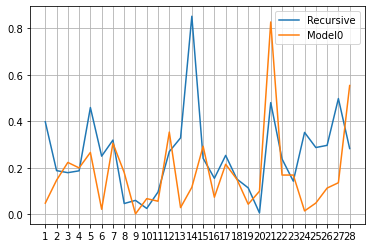

In [408]:
level = 1
plt.plot([i for i in range(1,29)], [analyzeDay(predictions, i, level) for i in range(1,29)])
plt.plot([i for i in range(1,29)], [analyzeDay(bestModel, i, level) for i in range(1,29)])
plt.legend(["Recursive","Model0"])
plt.xticks(range(1,29))
plt.grid(True)
plt.show()

In [548]:
temp_count = 0
mod_preds = m5.transformer[12](predictions)
mod_actuals = m5.transformer[12](m5.actuals)
arr1 = np.square(mod_preds - mod_actuals)
arr2 = np.square(np.round(m5.transformer[12](predictions)) - m5.transformer[12](m5.actuals))
for idx in range(30490):
    a = arr1[idx].sum()
    b = arr2[idx].sum()
    if a < b:
        temp_count += 1
print(temp_count)

22033


In [470]:
def getFudged2(y_pred, y_true):
    residual = (y_true - y_pred).astype("float")
    full_store_range = range(3049 * 8 + 2226, 3049 * 9)
    return np.sqrt(np.sum(np.square(residual[full_store_range].sum(axis = 0))))

def getNormal2(y_pred, y_true):
    residual = (y_true - y_pred).astype("float")
    fudger = 3049 * 8 + 2297
    residual[fudger] = 0
    full_store_range = range(3049 * 8 + 2226, 3049 * 9)
    return np.sqrt(np.sum(np.square(residual[full_store_range].sum(axis = 0))))

def compare(predictions):
    temp_preds = np.copy(predictions)
    fudger = 3049 * 8 + 2297
    temp_preds[fudger] = 0
    return m5.WRMSSE(predictions).computeLevelLosses(9)[62], m5.WRMSSE(temp_preds).computeLevelLosses(9)[62]

In [464]:
fudger = 3049 * 8 + 2297
predictions[fudger]

array([73.40302472, 53.90781358, -1.29858219, -6.19285436,  4.22879762,
        9.17956724,  0.39135545, 81.62706125, 95.92853078, 16.87490097,
       74.78096325, 81.49446273, 18.86907478, 58.28664483, 52.91210572,
        8.27210414, 33.85531025, 52.51515099,  9.94858255, 50.34414281,
       64.93558264, 16.55557991,  4.78382894,  8.57977991,  2.00367538,
       11.11250415, 19.87399582, 26.66190655])

In [471]:
compare(predictions)

(0.003113939378169548, 0.0033517283823194205)

In [467]:
predictions[fudger]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

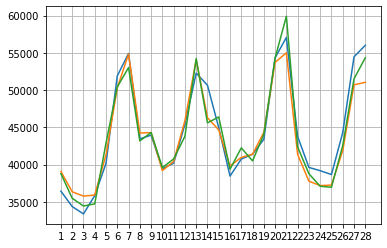

In [409]:
level = 1
plt.plot(range(1,29), [np.sum(m5.transformer[level](predictions), axis = 0)[day] for day in range(28)])
plt.plot(range(1,29), [np.sum(m5.transformer[level](bestModel), axis = 0)[day] for day in range(28)])
plt.plot(range(1,29), [np.sum(m5.transformer[level](m5.actuals), axis = 0)[day] for day in range(28)])
plt.xticks(range(1,29))

plt.grid(True)

In [215]:
np.sum(m5.transformer[1](predictions), axis=0)

39433.77333782457

In [ ]:
combined = np.concatenate((predictions[:,:4], bestModel[:,4:6], predictions[:,6:8], bestModel[:,8:]), axis=1)

In [170]:
m5.WRMSSE(combined).getTotalLoss()

0.5299977413302546

In [164]:
m5.WRMSSE(bestModel).getTotalLoss()

0.5360565806952426

In [154]:
bestModel = m5.clean(pd.read_csv("Submissions/nt_model_0.csv"))

In [111]:
bestLoss = m5.WRMSSE(bestModel)

In [113]:
bestLoss.getLossByLevel()

array([0.02061844, 0.02763055, 0.03697214, 0.02917736, 0.0364879 ,
       0.03603486, 0.04293453, 0.04489379, 0.0513724 , 0.06998631,
       0.07011418, 0.06983413])

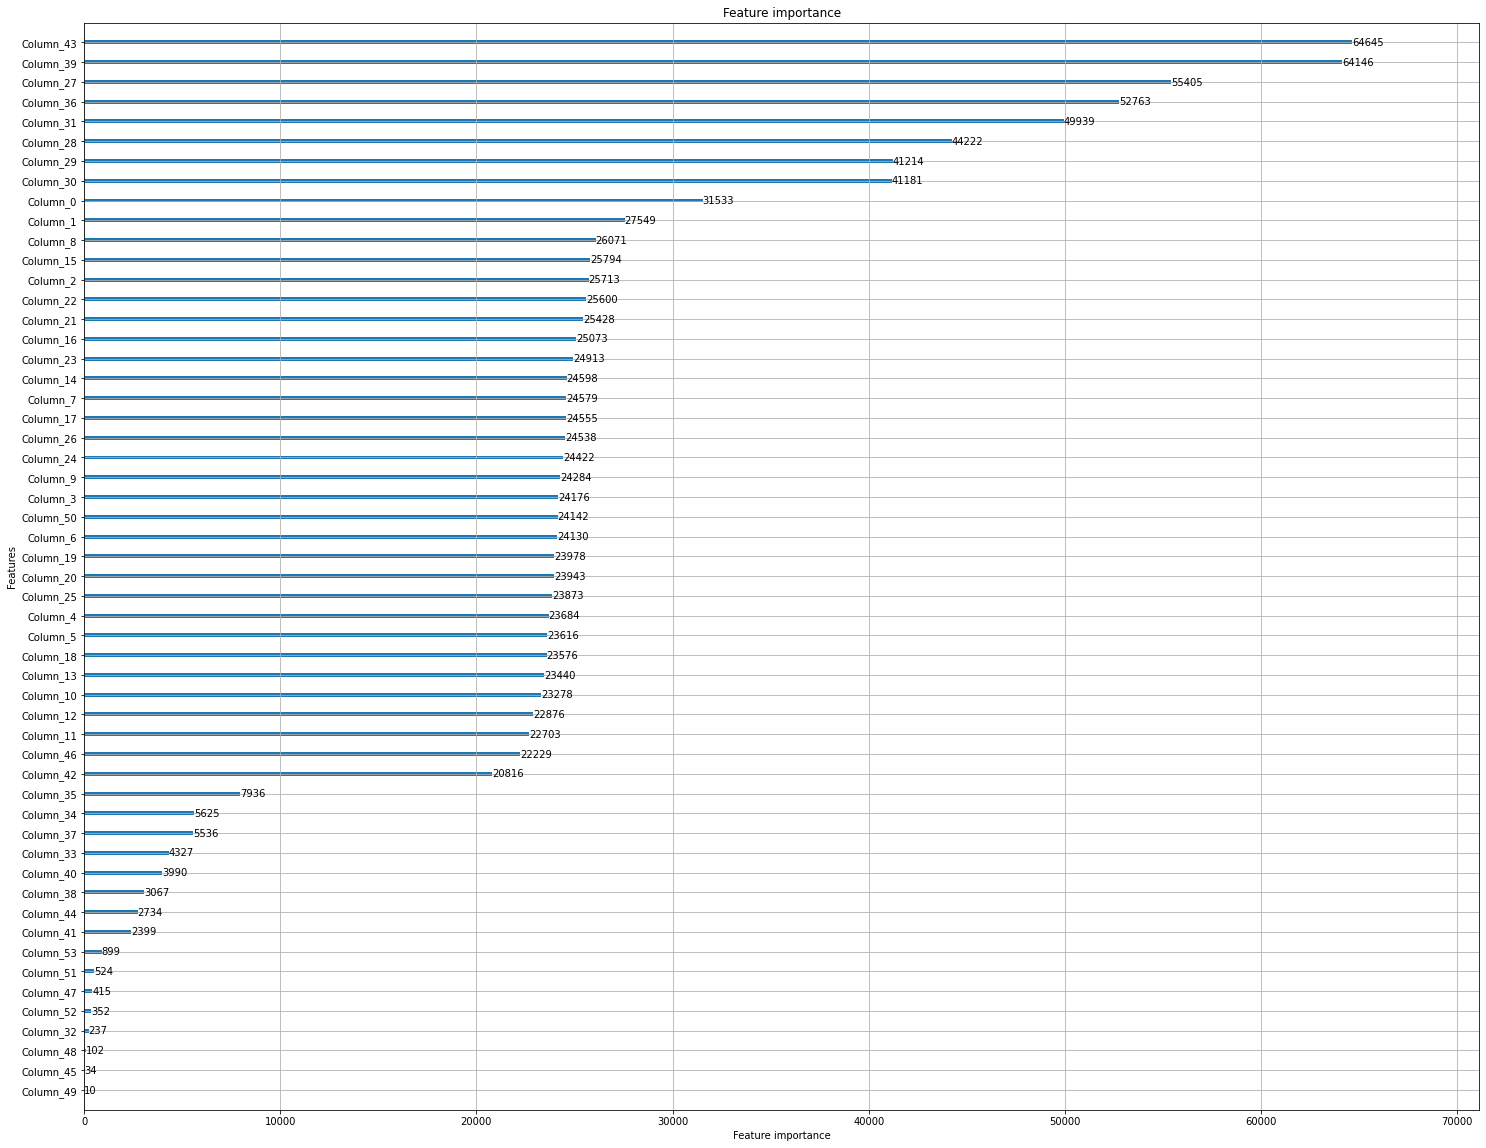

In [390]:
lgb.plot_importance(model, height=0.2, figsize=(25,20))

In [360]:
categories[:-2][-30:][14:16]

[55, 56]

In [392]:
categories[-10:]

[44, 45, 46, 47, 48, 49, 50, 51, 52, 53]

In [262]:
print(Counter(list(m5.calendar.iloc[1200:][m5.calendar["event_name_2"]] )))
print(Counter(list(m5.calendar.iloc[1200:]["event_name_1"])))

Counter({nan: 767, "Father's day": 2})
Counter({nan: 706, 'MemorialDay': 3, 'NBAFinalsStart': 3, 'NBAFinalsEnd': 3, 'Ramadan starts': 3, 'IndependenceDay': 2, 'Eid al-Fitr': 2, 'LaborDay': 2, 'EidAlAdha': 2, 'ColumbusDay': 2, 'Halloween': 2, 'VeteransDay': 2, 'Thanksgiving': 2, 'Chanukah End': 2, 'Christmas': 2, 'NewYear': 2, 'OrthodoxChristmas': 2, 'MartinLutherKingDay': 2, 'SuperBowl': 2, 'ValentinesDay': 2, 'PresidentsDay': 2, 'LentStart': 2, 'LentWeek2': 2, 'Purim End': 2, 'StPatricksDay': 2, 'Easter': 2, 'Pesach End': 2, 'OrthodoxEaster': 2, 'Cinco De Mayo': 2, "Mother's day": 2, "Father's day": 1})


First thing - add in special days

Try running models - both symmetric and aysmetric (symmetric scored .606, fixed mothers day error but now underpredicts heavily on the portion after mothers day, this could be fixed with assymetric loss)

add in unique item identifier (as well as max_bin by node)

try running models - both symmetric and asymmetric

In [244]:
m5.WRMSSE(np.concatenate((predictions[:,:13], bestModel[:,13:14], predictions[:,14:]),axis = 1)).getTotalLoss()

0.6016827523199795

In [489]:
m5.transformer[9](all_data)

array([[ 528.,  489.,  409., ...,  471.,  621.,  641.],
       [  28.,    9.,    6., ...,   56.,   49.,   73.],
       [ 361.,  350.,  279., ...,  695.,  933., 1022.],
       ...,
       [ 152.,  138.,  127., ...,  261.,  324.,  317.],
       [ 583.,  585.,  575., ...,  507.,  505.,  557.],
       [2293., 2383., 1841., ..., 1897., 2411., 2233.]])

## Training a pre-trained Model (Level 9 + 12 Gradient) with Level 6 Loss

In [745]:
len(l8_idxs)

31

In [907]:
[1,2] + [2,3]

[1, 2, 2, 3]

In [850]:
hello = np.array([6,5,3,2])
def arr(hello):
    hello[0] = 5

In [852]:
hello

array([5, 5, 3, 2])

In [740]:
level1MSE(np.array([[1, 2, 3], [3, 4, 5]]), 3)[0]

array([ -8., -12., -16., ...,  -8., -12., -16.])

In [742]:
custom_asymmetric_train(np.array([6,1,4]), np.array([6,5,3]))

(array([-0. , -9.2,  2. ]), array([2.3, 2.3, 2. ]))

In [816]:
%%time
for idx, (a, b) in enumerate(zip(np.random.rand(10000),np.random.rand(10000))):
    pass

CPU times: user 3.23 ms, sys: 412 µs, total: 3.64 ms
Wall time: 3.13 ms


In [815]:
%%time
temp_count = 0 
for a, b, c in zip(np.zeros(10000),np.random.rand(10000),np.random.rand(10000)):
    # print(a,b,c)
    pass

CPU times: user 3.86 ms, sys: 198 µs, total: 4.06 ms
Wall time: 3.76 ms


In [819]:
np.concatenate((np.tile([1,2,3], 2), np.tile([5,6,7], 3)))

array([1, 2, 3, 1, 2, 3, 5, 6, 7, 5, 6, 7, 5, 6, 7])

[4160, 1490, 5320, 5150, 2160, 3980, 8230]

In [829]:
np.concatenate((np.array([2]), np.array([1])))

array([2, 1])

In [849]:
df.iloc[1612]

id          FOODS_1_001_CA_1_validation
item_id                     FOODS_1_001
dept_id                         FOODS_1
cat_id                            FOODS
store_id                           CA_1
                       ...             
d_1909                                1
d_1910                                0
d_1911                                1
d_1912                                1
d_1913                                0
Name: 1612, Length: 1919, dtype: object

In [836]:
categories

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

In [848]:
%%time
dept_idxs + [594503503]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


[0, 416, 565, 1097, 1612, 1828, 2226, 594503503]

In [842]:
2+2

4

In [123]:
test_arr = np.array([1,2,3,4])
test_tuple = test_arr, 5
test_arr[0] = 100
print(test_tuple)

(array([100,   2,   3,   4]), 5)
